In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np
import reddit_parser

from datetime import datetime, timedelta
import sys
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

cachedStopWords = stopwords.words("english")


In [2]:
def get_bodies(items):
    """Gets all of the bodies associated with inputted posts or comments"""
    return [item['body'] for item in items]


In [24]:
def concatenate_comments_to_post(post_body, comments):
    """Returns a combined document of a post body and comment bodies"""
    comment_bodies = get_bodies(comments)
    document = post_body

    for comment in comment_bodies:
        document += "\n" + comment
    
    with open('f.txt', 'wb') as f:
        f.write(str(document.encode('utf8')))
        
    document = ' '.join([word for word in document.split() if word not in cachedStopWords])
    with open('fc.txt', 'wb') as f:
        f.write(str(document.encode('utf8')))
    return document

In [4]:
def build_documents(post_pairs):
    """Combines the body and comments of a post into a single document
    Returns a list of documents
    """
    documents = []

    for post, post_body in post_pairs:
        comments = reddit_parser.get_post_comments(post)
        documents.append(concatenate_comments_to_post(post_body, comments))

    return documents

In [5]:
def get_min_max_time(posts):
    """Returns the oldest and newest times for any post in the set"""
    min = sys.maxsize
    max = -sys.maxsize - 1

    for post in posts:
        if post['created'] < min:
            min = post['created']
        if post['created'] > max:
            max = post['created']

    return (min, max)


In [6]:
def generate_time_range(min_time, max_time, num_topics):
    """Create an empty map of the time ranges from the min time to the max time"""
    times = {}

    while min_time < max_time:
        times[min_time] = np.zeros(num_topics)
        min_time += timedelta(hours = 1)

    return times


In [7]:
def increment_time_range_for_topic(time_topic_distribution, topic, timestamp):
    """Increments the topic count at a specific time in the distribution"""
    for time in sorted(time_topic_distribution.keys()):
        if timestamp < time:
            time_topic_distribution[time][topic] += 1
            print time
            break


In [8]:
def format_topic_counts(time_topic_distribution):
    topic_counts = [[], [], [], [], []]
    for time in time_topic_distribution:
        topics = time_topic_distribution[time]
        for i in range(0, len(topics)):
            topic_counts[i].append(topics[i])

    return topic_counts


In [9]:
subreddits = ['news']
limit = 100
user_agent = "ResearchBot"
num_topics = 5
num_words = 10

In [10]:
posts = reddit_parser.format_posts(reddit_parser.get_posts(subreddits, limit))
post_bodies = get_bodies(posts)
timestamps = [post["created"] for post in posts]
datetime_stamps = [str(datetime.fromtimestamp(timestamp)) for timestamp in timestamps]
datetime_stamps

['2017-10-22 14:14:46',
 '2017-10-22 15:24:55',
 '2017-10-22 11:27:12',
 '2017-10-22 17:56:48',
 '2017-10-22 02:02:03',
 '2017-10-22 15:20:06',
 '2017-10-22 18:23:57',
 '2017-10-22 13:45:00',
 '2017-10-22 16:18:39',
 '2017-10-22 19:08:18',
 '2017-10-22 18:01:50',
 '2017-10-22 06:52:26',
 '2017-10-22 09:38:11',
 '2017-10-22 17:54:42',
 '2017-10-21 15:55:07',
 '2017-10-22 14:27:28',
 '2017-10-22 19:01:55',
 '2017-10-22 15:20:36',
 '2017-10-22 00:28:56',
 '2017-10-22 03:47:06',
 '2017-10-21 21:13:27',
 '2017-10-22 17:09:34',
 '2017-10-22 03:26:11',
 '2017-10-22 17:28:56',
 '2017-10-22 17:47:19',
 '2017-10-21 13:42:06',
 '2017-10-22 19:02:46',
 '2017-10-22 05:24:14',
 '2017-10-22 07:54:22',
 '2017-10-21 20:58:13',
 '2017-10-22 18:33:12',
 '2017-10-22 06:02:42',
 '2017-10-22 20:14:25',
 '2017-10-22 13:01:51',
 '2017-10-22 20:22:16',
 '2017-10-22 04:59:03',
 '2017-10-22 18:21:08',
 '2017-10-22 17:25:52',
 '2017-10-21 19:42:21',
 '2017-10-21 16:26:21',
 '2017-10-22 13:20:09',
 '2017-10-21 07:

In [25]:
documents = build_documents(zip(posts, post_bodies))

In [12]:
# michael's code
vectorizer = CountVectorizer()
vectorizer.fit(documents)
document_word_vectors = vectorizer.transform(documents)

word_to_index = vectorizer.vocabulary_
index_to_word = np.chararray(len(word_to_index), itemsize=100)
for word in word_to_index:
    index = word_to_index[word]
    try:
        index_to_word[index] = word
    except UnicodeEncodeError:
        print("")

lda = LDA(n_topics=num_topics)
lda.fit(document_word_vectors)

# p(word|topic)  (n_topics X n_words)
w_z = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# p(topic|document)  (n_documents X n_topics)
z_d = lda.transform(document_word_vectors)

top_word_args = np.argsort(w_z, axis=1)[:,-1*num_words:]
top_words = np.chararray((w_z.shape[0], num_words, 2), itemsize=100)
for i in range(0, num_topics):
    top_words[i,:,0] = index_to_word[top_word_args[i]]
    top_words[i,:,1] = w_z[i,top_word_args[i]]
    
top_words
    # end michael's code

/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


chararray([[['that', '0.00108891266105'],
            ['robert', '0.00111312270673'],
            ['the', '0.00120290031724'],
            ['you', '0.0012897896195'],
            ['don', '0.00138605045576'],
            ['people', '0.00141147894997'],
            ['mugabe', '0.00183609345246'],
            ['like', '0.00183908431493'],
            ['un', '0.00242696908758'],
            ['it', '0.00380886638409']],

           [['this', '0.000754956591229'],
            ['re', '0.000901747337438'],
            ['they', '0.000912569980784'],
            ['that', '0.000951989557533'],
            ['don', '0.000989188410939'],
            ['the', '0.00103739621712'],
            ['you', '0.00119221927799'],
            ['like', '0.00125430792863'],
            ['people', '0.00178403479488'],
            ['it', '0.00214800421425']],

           [['get', '0.00471646295011'],
            ['they', '0.00496717396723'],
            ['would', '0.00536903136066'],
            ['don', '0.005843507

In [13]:
min_time, max_time = get_min_max_time(posts)

datetime_min_time = datetime.fromtimestamp(min_time)
datetime_max_time = datetime.fromtimestamp(max_time)

time_topic_distribution = generate_time_range(datetime_min_time, datetime_max_time, num_topics)

document_topics = np.argmax(z_d, axis = 1)

for i in range(0, len(z_d)):
    doc_timestamp = timestamps[i]
    doc_datetime = datetime.fromtimestamp(doc_timestamp)
    document_topic = document_topics[i]
    #print doc_datetime
    increment_time_range_for_topic(time_topic_distribution, document_topic, doc_datetime)

time_topic_distribution

2017-10-22 15:08:07
2017-10-22 16:08:07
2017-10-22 12:08:07
2017-10-22 18:08:07
2017-10-22 02:08:07
2017-10-22 16:08:07
2017-10-22 19:08:07
2017-10-22 14:08:07
2017-10-22 17:08:07
2017-10-22 20:08:07
2017-10-22 18:08:07
2017-10-22 07:08:07
2017-10-22 10:08:07
2017-10-22 18:08:07
2017-10-21 16:08:07
2017-10-22 15:08:07
2017-10-22 19:08:07
2017-10-22 16:08:07
2017-10-22 01:08:07
2017-10-22 04:08:07
2017-10-21 22:08:07
2017-10-22 18:08:07
2017-10-22 04:08:07
2017-10-22 18:08:07
2017-10-22 18:08:07
2017-10-21 14:08:07
2017-10-22 19:08:07
2017-10-22 06:08:07
2017-10-22 08:08:07
2017-10-21 21:08:07
2017-10-22 19:08:07
2017-10-22 06:08:07
2017-10-22 13:08:07
2017-10-22 05:08:07
2017-10-22 19:08:07
2017-10-22 18:08:07
2017-10-21 20:08:07
2017-10-21 17:08:07
2017-10-22 14:08:07
2017-10-21 08:08:07
2017-10-21 15:08:07
2017-10-22 19:08:07
2017-10-22 00:08:07
2017-10-22 08:08:07
2017-10-22 11:08:07
2017-10-22 00:08:07
2017-10-22 09:08:07
2017-10-22 04:08:07
2017-10-22 05:08:07
2017-10-22 09:08:07


{datetime.datetime(2017, 10, 20, 13, 8, 7): array([ 0.,  0.,  0.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 14, 8, 7): array([ 0.,  0.,  1.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 15, 8, 7): array([ 0.,  0.,  0.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 16, 8, 7): array([ 0.,  0.,  0.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 17, 8, 7): array([ 0.,  0.,  1.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 18, 8, 7): array([ 0.,  0.,  2.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 19, 8, 7): array([ 0.,  0.,  0.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 20, 8, 7): array([ 0.,  0.,  1.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 21, 8, 7): array([ 0.,  0.,  0.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 22, 8, 7): array([ 0.,  0.,  1.,  0.,  0.]),
 datetime.datetime(2017, 10, 20, 23, 8, 7): array([ 0.,  0.,  1.,  0.,  0.]),
 datetime.datetime(2017, 10, 21, 0, 8, 7): array([ 0.,  0.,  1.,  0.,  0.]),
 datetime.datetime(2017, 10, 21, 1, 8, 7): array([ 0.,  0.,  0., 

In [14]:
z_d

array([[  5.98941726e-05,   5.97997442e-05,   9.99760743e-01,
          5.97714488e-05,   5.97915198e-05],
       [  4.97486740e-05,   4.97017607e-05,   9.99801099e-01,
          4.97292165e-05,   4.97213623e-05],
       [  6.46304987e-05,   6.46062731e-05,   9.99741512e-01,
          6.45988228e-05,   6.46520670e-05],
       [  1.18185188e-04,   1.17886995e-04,   9.99527991e-01,
          1.17929433e-04,   1.18007867e-04],
       [  5.76910808e-05,   5.76173451e-05,   9.99769452e-01,
          5.76152970e-05,   5.76238490e-05],
       [  8.54946955e-03,   4.66223943e-04,   9.90052027e-01,
          4.66125888e-04,   4.66153971e-04],
       [  1.23448854e-04,   1.23332683e-04,   9.99506067e-01,
          1.23406380e-04,   1.23745149e-04],
       [  5.32441827e-05,   5.32019898e-05,   9.99787081e-01,
          5.32167756e-05,   5.32563079e-05],
       [  1.47990320e-04,   1.47890270e-04,   9.99407985e-01,
          1.47945394e-04,   1.48189063e-04],
       [  6.83225396e-04,   6.8272373

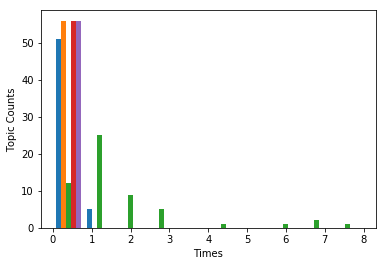

In [15]:
topic_counts = format_topic_counts(time_topic_distribution)

num_bars = len(timestamps)
width = .35
for topic_count in topic_counts:
    counts = [[int(tc) for tc in tcs] for tcs in topic_counts]
    plt.hist(counts)

plt.xlabel('Times')
plt.ylabel('Topic Counts')
#plt.xticks(np.arange(6), datetime_stamps)
#plt.yticks(np.arange(0, 10, 1))
plt.show()